# Analysis of activations on network layers

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2
import sys  
# sys.path.append('..')
sys.path.insert(0, '../')

In [2]:
from python.model import LayerModel
from python import visualization
from python.utils import get_train_test, train_knn_with_activations, get_neighbours_idxs_on_layers

In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from numpy import expand_dims
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import innvestigate

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load data

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
# test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))


In [6]:
train_images.shape

(50000, 32, 32, 3)

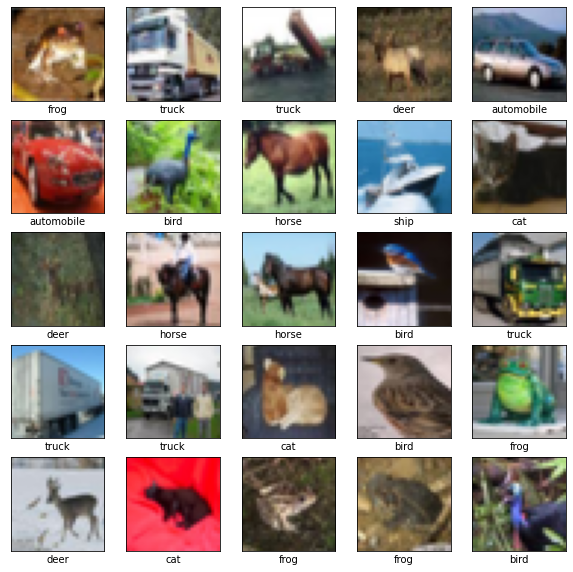

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Train model

In [8]:
# train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
# test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [9]:
x = layers.Input((32, 32, 3), name='input_layer')
y = layers.Conv2D(32, (3, 3), activation='relu')(x)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dense(10)(y)
model = Model(x, y)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 146us/sample - loss: 1.4916 - accuracy: 0.4609 - val_loss: 1.1732 - val_accuracy: 0.5837
Epoch 2/10
50000/50000 [==============================] - 5s 105us/sample - loss: 1.1087 - accuracy: 0.6078 - val_loss: 1.0620 - val_accuracy: 0.6206
Epoch 3/10
50000/50000 [==============================] - 6s 111us/sample - loss: 0.9779 - accuracy: 0.6588 - val_loss: 0.9591 - val_accuracy: 0.6597
Epoch 4/10
50000/50000 [==============================] - 6s 110us/sample - loss: 0.8840 - accuracy: 0.6900 - val_loss: 0.9309 - val_accuracy: 0.6778
Epoch 5/10
50000/50000 [==============================] - 5s 109us/sample - loss: 0.8172 - accuracy: 0.7135 - val_loss: 0.8692 - val_accuracy: 0.6943
Epoch 6/10
50000/50000 [==============================] - 6s 117us/sample - loss: 0.7583 - accuracy: 0.7338 - val_loss: 0.8811 - val_accuracy: 0.6983
Epoch 7/10
50000/50000 [==========================

## Test activations

### Activation analysis

We applied workflow to visualize and evaluate similarity of activations for instances from same class.
* train KNN classifier from subset of test images
* predict class from activations for each class

In [12]:
# Create test and train set from original test 
a_labels, b_labels = get_train_test(test_labels.squeeze())
original_pred = model.predict(test_images).argmax(axis=1)
a_org_pred, b_org_pred = get_train_test(original_pred)

Layer:  1


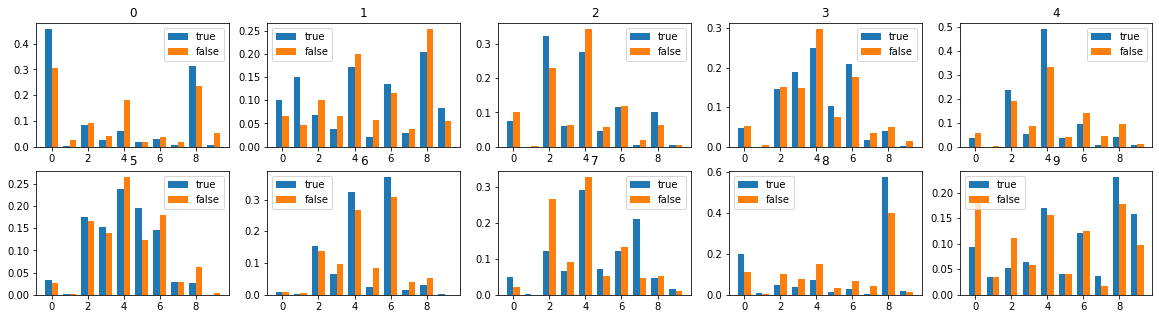

Layer:  2


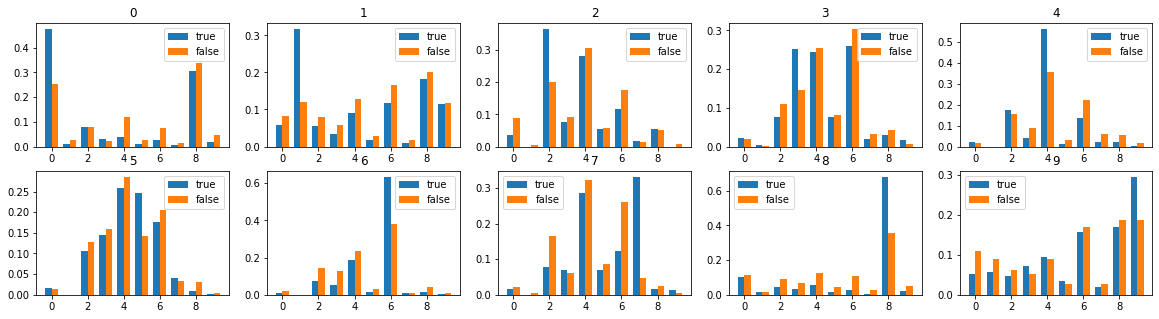

Layer:  3


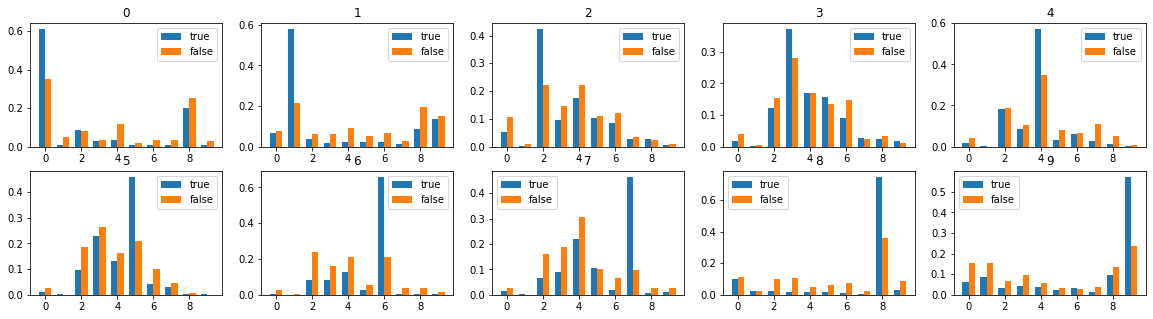

Layer:  4


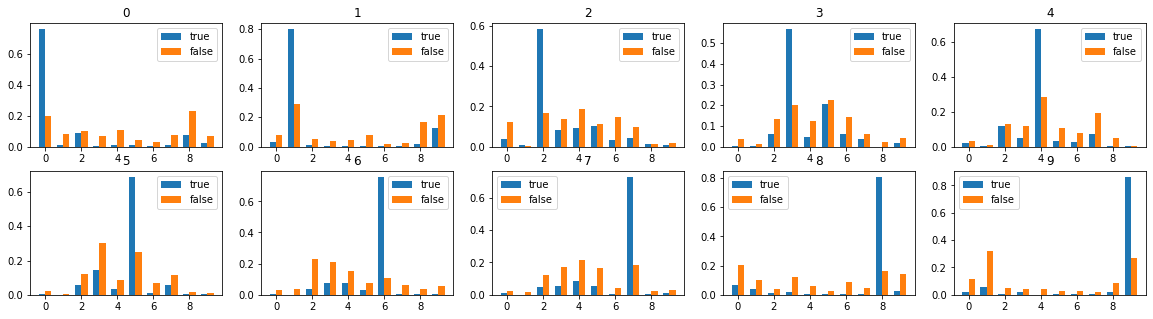

In [14]:
# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7])
layers_activations = layer_model.predict(test_images)

x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

for i, layer_activations in enumerate(layers_activations):
    print('Layer: ', i + 1)
    a_activations, b_activations = get_train_test(layer_activations)
    
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)
    knn_prediction = neigh.predict_proba(b_activations)
    
    visualization.plot_layers_activations(knn_prediction, b_org_pred, b_labels)


### Prediction of miss classification

In [15]:
a_data = []
b_data = []

# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7])
layers_activations = layer_model.predict_layers_activations(test_images)

for layer_activations in layers_activations:
    a_activations, b_activations = get_train_test(layer_activations)
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)

    a_pred = neigh.predict_proba(a_activations[a_labels==0])
    b_pred = neigh.predict_proba(b_activations[b_labels==0])
    
    a_data.append(a_pred)
    b_data.append(b_pred)

a_data = np.stack(a_data, axis=1)
b_data = np.stack(b_data, axis=1) 
a_0_labels = a_labels[a_labels==0] == a_org_pred[a_labels==0]
b_0_labels = b_labels[b_labels==0] == b_org_pred[b_labels==0]

In [16]:
a_data = a_data.reshape((a_data.shape[0], a_data.shape[1] * a_data.shape[2]))
b_data = b_data.reshape((b_data.shape[0], b_data.shape[1] * b_data.shape[2]))

In [17]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(a_data, a_0_labels)
pred = clf.predict(b_data)

In [19]:
print(classification_report(pred, b_0_labels))

              precision    recall  f1-score   support

       False       0.69      0.61      0.65        57
        True       0.85      0.88      0.86       137

    accuracy                           0.80       194
   macro avg       0.77      0.75      0.76       194
weighted avg       0.80      0.80      0.80       194



Analysis of cases predicted as airplane


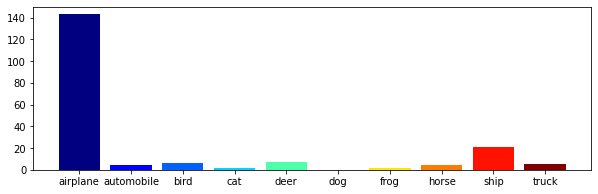

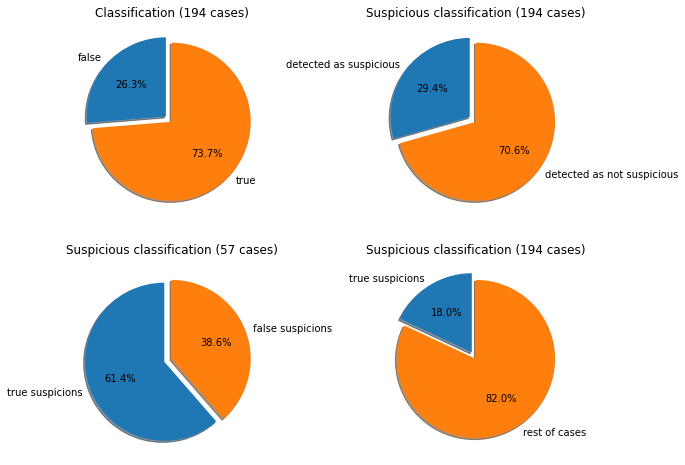

In [21]:
visualization.plot_suspicions_stats(pred, b_org_pred[b_labels==0], 0, class_names)

### Correct prediction of suspisions

Layer:  1


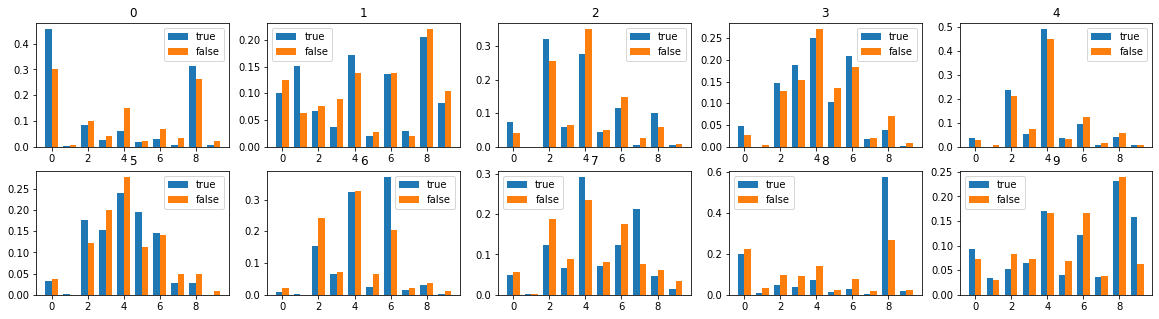

Layer:  2


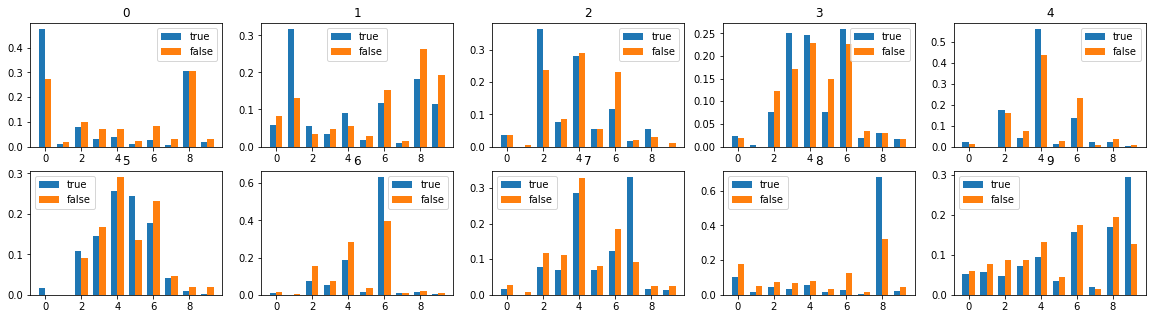

Layer:  3


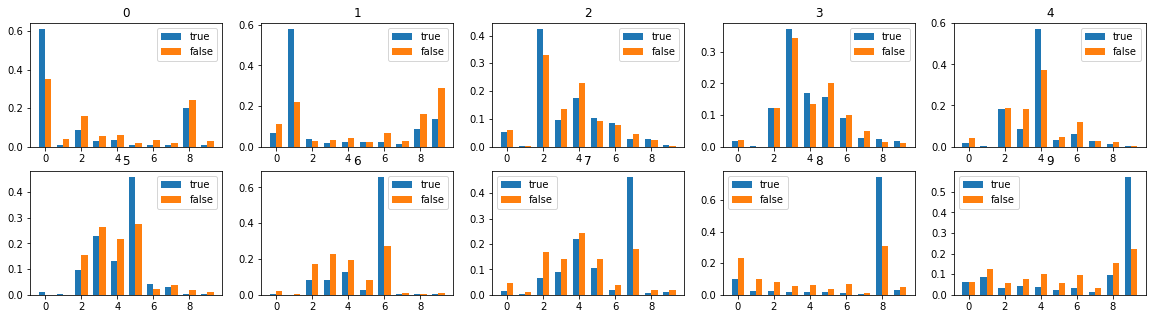

Layer:  4


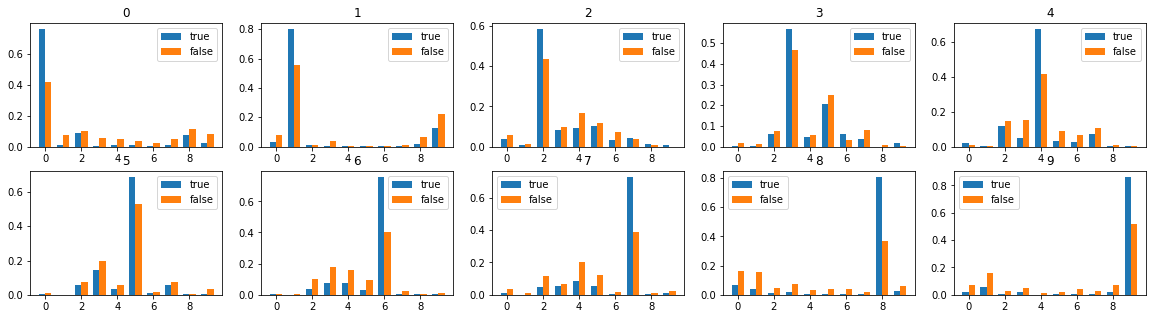

In [25]:
# Create test and train set from original test 
a_labels, b_labels = get_train_test(test_labels.squeeze())
original_pred = model.predict(test_images).argmax(axis=1)
a_org_pred, b_org_pred = get_train_test(original_pred)

# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7])
layers_activations = layer_model.predict_layers_activations(test_images)

for i, layer_activations in enumerate(layers_activations):
    print('Layer: ', i + 1)
    a_activations, b_activations = get_train_test(layer_activations)
    
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)
    knn_prediction = neigh.predict_proba(b_activations)
    
    visualization.plot_layers_activations_for_prediction(knn_prediction, b_org_pred, b_labels)

In [26]:
a_data = []
b_data = []

for layer_activations in layers_activations:
    a_activations, b_activations = get_train_test(layer_activations)
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)

    a_pred = neigh.predict_proba(a_activations)
    b_pred = neigh.predict_proba(b_activations)
    
    a_data.append(a_pred)
    b_data.append(b_pred)

a_data = np.stack(a_data, axis=1)
b_data = np.stack(b_data, axis=1) 
a_data = a_data.reshape((a_data.shape[0], a_data.shape[1] * a_data.shape[2]))
b_data = b_data.reshape((b_data.shape[0], b_data.shape[1] * b_data.shape[2]))

              precision    recall  f1-score   support

       False       0.65      0.51      0.57        61
        True       0.79      0.87      0.83       130

    accuracy                           0.75       191
   macro avg       0.72      0.69      0.70       191
weighted avg       0.74      0.75      0.75       191

Analysis of cases predicted as airplane


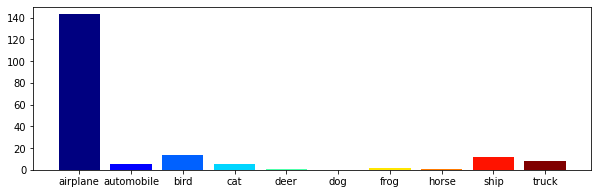

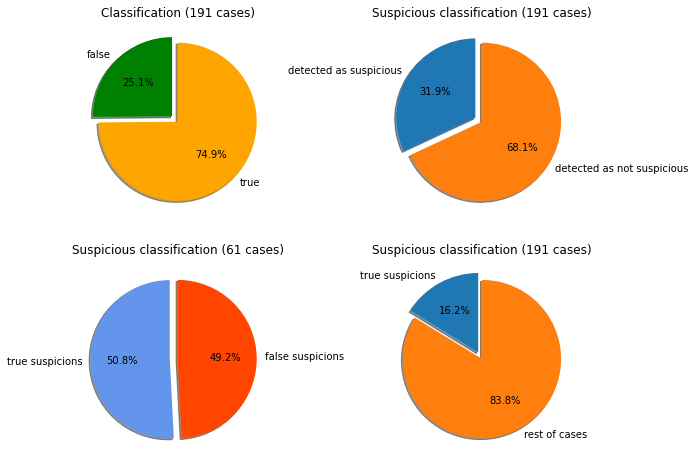

In [63]:
label = 0
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

clf.fit(a_data[a_org_pred==label], a_labels[a_org_pred==label] == label)

pred = clf.predict(b_data[b_org_pred==label])
print(classification_report(pred, b_labels[b_org_pred==label] == label))
visualization.plot_suspicions_stats(pred, b_labels[b_org_pred==label], label, class_names)

### Visualization of path ( individual prediction )

In [12]:
# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7], class_names)
# divide test images to train and test subset
a_images, b_images = get_train_test(test_images)
a_labels, b_labels = get_train_test(test_labels.squeeze())

# train KNN for each layer
a_pred_labels = model.predict(a_images).argmax(1)
layer_model.train(a_images, a_labels, a_pred_labels)


In [13]:
label = 0
b_pred_labels = model.predict(b_images).argmax(1)
susp_pred = layer_model.predict(b_images[b_pred_labels == label], label)
susp_imgs = b_images[b_pred_labels == label][susp_pred]
susp_labels = b_labels[b_pred_labels == label][susp_pred]

In [14]:
susp_indx = layer_model.get_neighbours_idxs_on_layers(susp_imgs)

original: ship   predicted: airplane


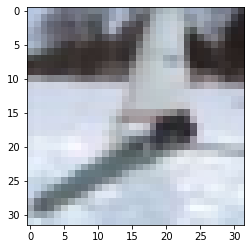

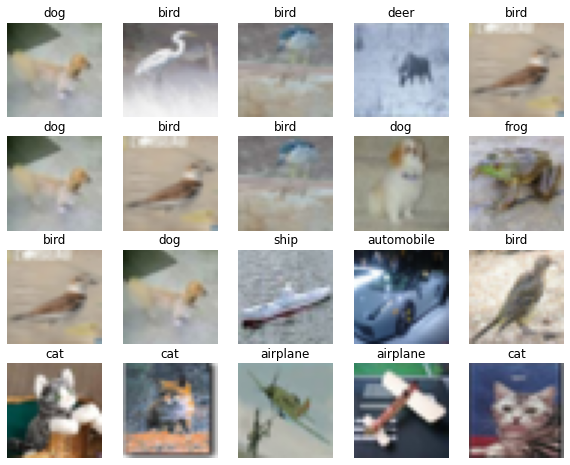

original: ship  predicted: airplane


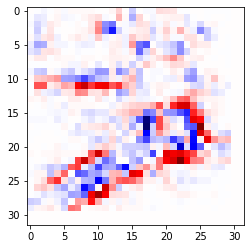

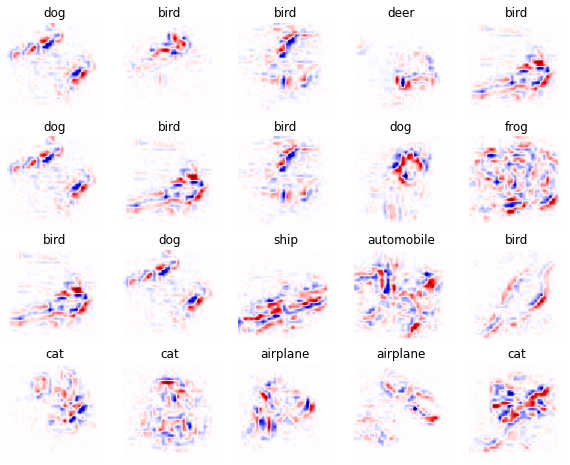

In [34]:
image_idx = 1
visualization.visualize_path(
    [x[image_idx] for x in susp_indx],
    a_images,
    a_labels,
    susp_imgs[image_idx],
    susp_labels[image_idx],
    b_pred_labels[b_pred_labels == label][susp_pred][image_idx],
    class_names
)

visualization.visualize_path_lrp(
    [x[image_idx] for x in susp_indx],
    a_images,
    a_labels,
    susp_imgs[image_idx],
    susp_labels[image_idx],
    b_pred_labels[b_pred_labels == label][susp_pred][image_idx],
    analyzer,
    class_names
)


In [16]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

In [ ]:
!pip install --use-feature=2020-resolver "git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0"

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-32b4f00z


Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x7febb4681f28>> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 538, in post_execute_hook
    _, pymtime = self._reloader.filename_and_mtime(sys.modules[modname])
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 184, in filename_and_mtime
    if not hasattr(module, '__file__') or module.__file__ is None:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py", line 50, in __getattr__
    module = self._load()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py", line 44, in _load
    module = _importlib.import_module(self.__name__)
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "